In [93]:
import yfinance as yf 
import numpy as np 
from scipy import optimize 
import pandas as pd
import matplotlib.pyplot as plt

In [182]:
TICKERS = ['AFX.DE', 'AIXA.DE', 'ARL.DE', 'BOSS.DE', 'EVT.DE', 'FRA.DE', 'G1A.DE', 'NEM.DE', 'SDF.DE', 'SRT.DE', 'UN01.DE']
DF = yf.download(TICKERS, start='2015-01-01', end='2019-12-31')['Close'].dropna(axis=0)
NUMBER_OF_SYMBOLS = len(DF.columns)

[*********************100%***********************]  11 of 11 completed


In [177]:
def get_risk_return(weights:np.array):

    # calulates stdev, mean, sharpe and diversification of portfolio 

    # input is global dataframe of prices and array of weights

    returns = np.log( 1+ DF.pct_change())
    mean = np.array(returns.mean())
    stdev = np.array(returns.std())
    cov_matrix = np.array(returns.cov())
    port_stdev = np.sqrt(np.matmul(np.matmul(weights, cov_matrix), weights)*250)
    port_mean = np.matmul(weights, mean)*250
    port_diversification = port_stdev/np.mean(stdev)

    return np.array([port_mean, port_stdev, port_mean/port_stdev, port_diversification])


def get_sharpe(weights:np.array):
    
    # calculate negative sharpe ratio

    # input is weights
    
    return  - get_risk_return(weights)[2]


def get_vol(weights:np.array):
    
    # get vola

    # input is weights
    
    return get_risk_return(weights)[1]


def get_div(weights:np.array):
    
    # get diversification

    # input is weights
    
    return get_risk_return(weights)[3]


def check_sum(weights:np.array):

    # return difference of sum of weights anf 1

    # input is weights

    return np.sum(weights) - 1


def do_monte_carlo(tries):

    # returns X random weights and their risk/return  

    # input is tries

    returns = np.zeros(tries)
    risks = np.zeros(tries)
    sharpes = np.zeros(tries)

    for i in range(tries):
        weights = np.array(np.random.random(NUMBER_OF_SYMBOLS))
        weights = weights/sum(weights)
        returns[i] = get_risk_return(weights)[0]
        risks[i] = get_risk_return(weights)[1]
        sharpes[i] = get_risk_return(weights)[2]
    return pd.DataFrame([returns, risks, sharpes]).T

In [187]:
def optimize_port(func):

    # get weights from optimizing for a function

    # prepare the bounds for the optimization -> max 100% per symbol
    bounds = tuple([0,1] for symbol in range(NUMBER_OF_SYMBOLS))

    # prepare the constraint (equalitlity constraint using check sum) -> sum must be 1
    constraints = ({'type': 'eq', 'fun': check_sum})

    # initial guess is 1/n per stock
    init_guess = NUMBER_OF_SYMBOLS* [1/NUMBER_OF_SYMBOLS]

    return dict(optimize.minimize(
        func,
        init_guess,
        method= 'SLSQP',
        bounds=bounds,
        constraints=constraints
    ))['x']



In [179]:
# do monte carlo to get feasible space
final = do_monte_carlo(50000)

#get max sharpe ratio weights
optimised_sharpe = optimize_port(get_sharpe)

#get min vola weights
optimised_vol = optimize_port(get_vol)

#get max diversification weights
optimised_div = optimize_port(get_div)

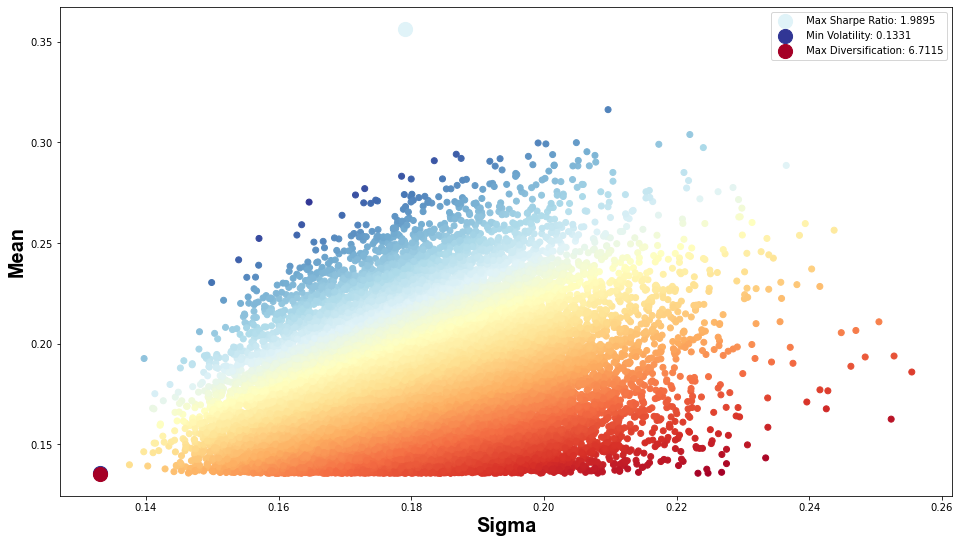

In [190]:
# get only the values below return of the min variance portfolio
final = final[final[0]>get_risk_return(list(optimised_vol))[0]]

font = {'family': 'Arial',
        'weight': 'bold',
        'size': 20,
        }

plt.figure(figsize=(16,9))

plt.scatter(
    x = final[1], 
    y = final[0], 
    c = final[2],
    cmap='RdYlBu'
)

plt.scatter(
    x = get_risk_return(list(optimised_sharpe))[1],
    y = get_risk_return(list(optimised_sharpe))[0], 
    color = '#e0f3f8',
    s = 200,
    label = f' Max Sharpe Ratio: {round(get_risk_return(list(optimised_sharpe))[2], 4)}'
)

plt.scatter(
    x = get_risk_return(list(optimised_vol))[1],
    y = get_risk_return(list(optimised_vol))[0], 
    color= '#313695',
    s = 200,
    label = f' Min Volatility: {round(get_risk_return(list(optimised_vol))[1], 4)}'
)

plt.scatter(
    x = get_risk_return(list(optimised_div))[1],
    y = get_risk_return(list(optimised_div))[0], 
    color= '#a50026',
    s = 200,
    label = f' Max Diversification: {round(get_risk_return(list(optimised_div))[3], 4)}'
)

plt.legend()
plt.xlabel('Sigma', font)
plt.ylabel('Mean', font)

plt.show()

In [191]:
CASH = 100000

for ind, item in enumerate(TICKERS):
    print(f'Get a weight of {round(optimised_sharpe[ind]*CASH, 4)} for item')


Get a weight of 35019.2421 for item
Get a weight of 0.0 for item
Get a weight of 0.0 for item
Get a weight of 0.0 for item
Get a weight of 10156.3929 for item
Get a weight of 0.0 for item
Get a weight of 0.0 for item
Get a weight of 9196.1905 for item
Get a weight of 0.0 for item
Get a weight of 275.6558 for item
Get a weight of 45352.5187 for item
